# Open and Globular Cluster Benchmark

To see the scattering of neural network and compared to ASPCAP

E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored
M67  and number of stars:  14
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 3.53s elapsed
Neural Network star cluster median abundances and uncertainty in median (ASPCAP)
[C/H] : -0.0376+/-0.0067  (-0.0391+/-0.0129)
[CI/H] : -0.1029+/-0.0051  (-0.1259+/-0.0139)
[N/H] : 0.4370+/-0.0070  (0.4304+/-0.0129)
[O/H] : 0.0493+/-0.0068  (0.0456+/-0.0057)
[Na/H] : 0.1137+/-0.0108  (0.1796+/-0.0226)
[Mg/H] : 0.0966+/-0.0078  (0.0882+/-0.0090)
[Al/H] : 0.1074+/-0.0049  (0.0923+/-0.0139)
[Si/H] : 0.0737+/-0.0098  (0.0701+/-0.0123)
[P/H] : 0.0362+/-0.0195  (0.0246+/-0.0190)
[S/H] : 0.0448+/-0.0056  (0.0331+/-0.0113)
[K/H] : 0.0726+/-0.0055  (0.0629+/-0.0120)
[Ca/H] : 0.0724+/-0.0065  (0.0610+/-0.0063)
[Ti/H] : 0.0705+/-0.0068  (0.0481+/-0.0070)
[TiII/H] : 0.0

C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


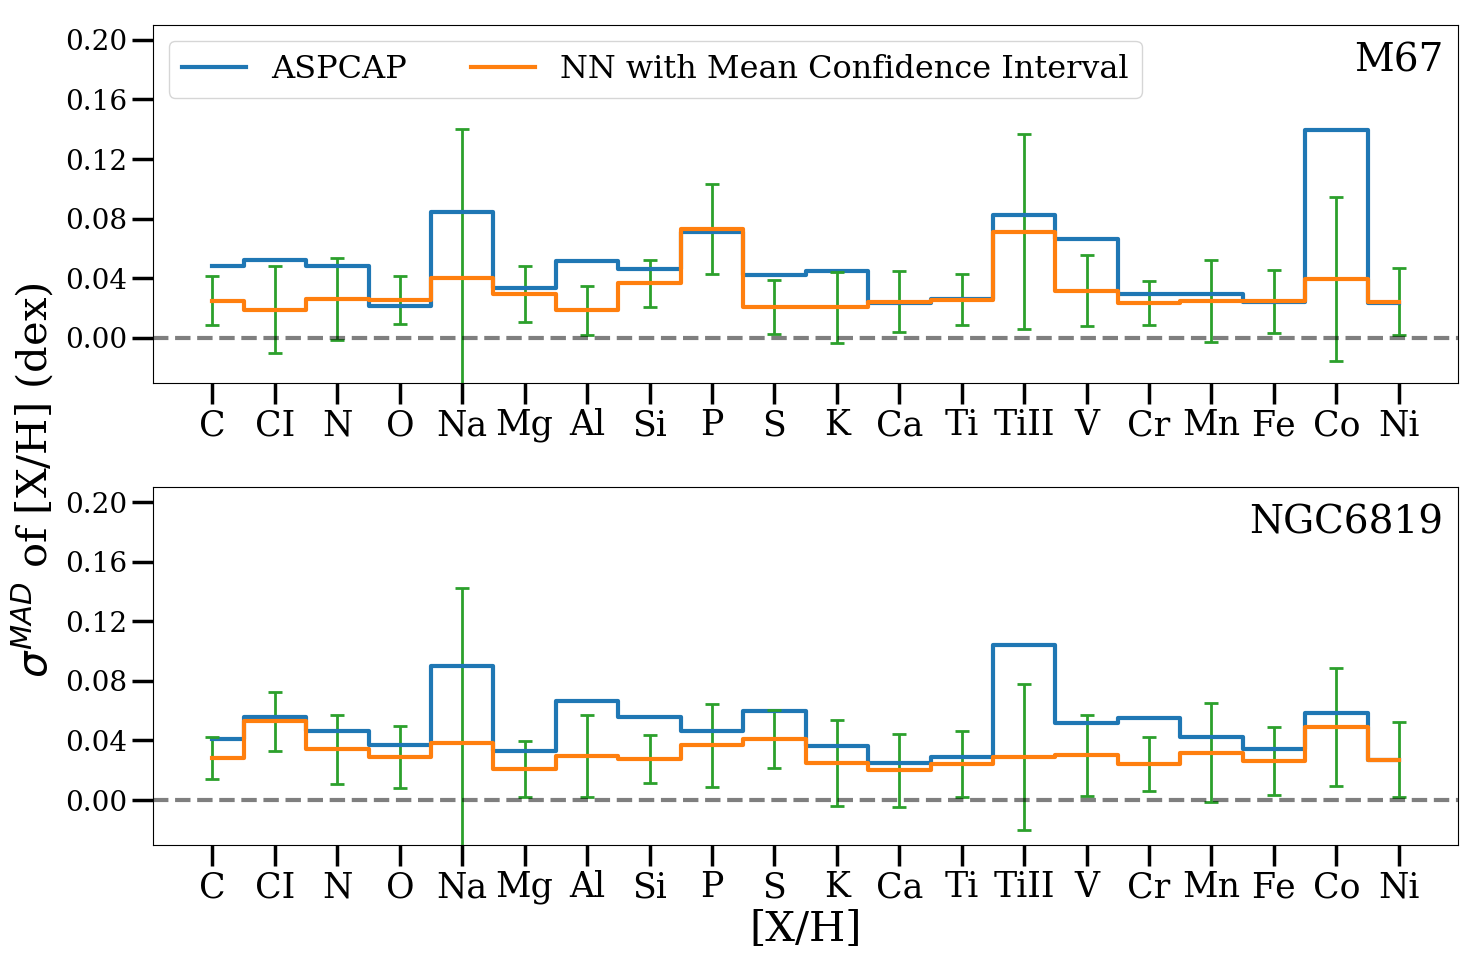

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
import astropy.io.ascii
from astropy.stats import mad_std
from astropy.io import fits

from astroNN.apogee import allstar
from astroNN.apogee import visit_spectra
from astroNN.apogee.chips import apogee_continuum
from astroNN.models import load_folder

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load APOGEE allstar file
all_star = fits.getdata(allstar(dr=14))
not_starflagged = (all_star['STARFLAG'] == 0)
# Same target bit used in the paper
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

# setup the continuum normalization function such that did the same thing as the standard procedure used in the paper
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# load the trained neural network model described in the paper
bcnn = load_folder('astroNN_0617_run001')
targetname = bcnn.targetname  # find out which neural repsondable to what

# load open cluster data
data = astropy.io.ascii.read('aj485195t4_mrt.txt')
uni_names = np.unique(np.array(data['col2']))  # find unique cluster name

# loop throught the clusters
for name in uni_names:
    # In the paper, we only plot these 3 clusters, M67, NGC6791 and NGC6819 in open cluster category
    if name not in ['M67', 'N6819']:
        continue
                
    # find all the APOGEE ID associated with that cluster
    apogeeid_name_idx = np.where(data['col2']==name)
     # find indices for those APOGEE ID in allstar
    indices = np.where(np.in1d(all_star['APOGEE_ID'][not_starflagged], data['col1'][apogeeid_name_idx]))[0]
    # retrieve info on those APOGEE spectra
    aid = all_star['APOGEE_ID'][not_starflagged][indices]
    loc_id = all_star['LOCATION_ID'][not_starflagged][indices]
    # 0-20 are indices representing output neurones from ASPCAP chemical abundances (C/H to Ni/H)
    aspcap_result = all_star['X_H'][not_starflagged][indices, 0:20]
    aspcap_result_err = all_star['X_H_ERR'][not_starflagged][indices, 0:20]

    # pre-allocation of spectra array
    spec = np.zeros((indices.shape[0], 7514))

    for counter, idx in enumerate(aid):
        apstar_file = fits.open(visit_spectra(dr=14, location=loc_id[counter], apogee=aid[counter], verbose=0))
        nvisits = apstar_file[0].header['NVISITS']
        # we want combined spectra
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        # continuum normalization of spectra
        _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
        spec[counter] = _spec
        apstar_file.close()

    print(name, ' and number of stars: ', indices.shape[0])
    
    # Bayesian Neural Network Inference
    pred, pred_err = bcnn.test(spec)
    # 2: are indices representing ASPCAP chemical abundances from output neurones (C/H to Ni/H)
    pred_scatter = mad_std(pred[:, 2:], axis=0)
    mean_uncertainty = np.mean(pred_err['total'][:, 2:], axis=0)
    aspcap_scatter = mad_std(aspcap_result, axis=0)
    
    if name=='M67':
        m67_nn_scatter = np.array(pred_scatter)
        m67_nn_m_uncer = np.array(mean_uncertainty)
        m67_aspcap = np.array(aspcap_scatter)
        
        m67_aspcap_mean = np.mean(aspcap_result, axis=0)
        m67_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])

        m67_nn_mean = np.mean(pred[:, 2:], axis=0)
        m67_nn_uncer_in_mean = mad_std(pred[:, 2:], axis=0) / np.sqrt(indices.shape[0])
            
        print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
        for i in range(20):
            print(bcnn.targetname[2:][i], f': {m67_nn_mean[i]:.{4}f}+/-{m67_nn_uncer_in_mean[i]:.{4}f}', 
                  f' ({m67_aspcap_mean[i]:.{4}f}+/-{m67_aspcap_uncer[i]:.{4}f})')
        print('=====================================\n')
        
    elif name=='N6819':
        n6819_nn_scatter = np.array(pred_scatter)
        n6819_nn_m_uncer = np.array(mean_uncertainty)
        n6819_aspcap = np.array(aspcap_scatter)
        n6819_aspcap = np.array(aspcap_scatter)

        n6819_aspcap_mean = np.mean(aspcap_result, axis=0)
        n6819_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])

        n6819_nn_mean = np.mean(pred[:, 2:], axis=0)
        n6819_nn_uncer_in_mean = mad_std(pred[:, 2:], axis=0) / np.sqrt(indices.shape[0])
            
        print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
        for i in range(20):
            print(bcnn.targetname[2:][i], f': {n6819_nn_mean[i]:.{4}f}+/-{n6819_nn_uncer_in_mean[i]:.{4}f}', 
                  f' ({n6819_aspcap_mean[i]:.{4}f}+/-{n6819_aspcap_uncer[i]:.{4}f})')
        print('======================================\n')
            
ml = MultipleLocator(0.04)

for ii in range(len(bcnn.targetname[2:])):
    bcnn.targetname[2+ii] = bcnn.targetname[2+ii].replace("/H]", "")
    bcnn.targetname[2+ii] = bcnn.targetname[2+ii].replace("[", "")

# setup plots
f, ax = plt.subplots(2, figsize=(15,10), dpi=100)

ax[0].plot(m67_aspcap, ls='steps-mid', linewidth=3., 
           label='ASPCAP')
ax[0].plot(m67_nn_scatter, ls='steps-mid', linewidth=3., 
           label='NN with Mean Confidence Interval')
ax[0].errorbar(np.arange(20), m67_nn_scatter, yerr=m67_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax[0].set_ylim((-0.03, 0.21))
ax[0].annotate("M67", xy=(0.92,0.87),xycoords='axes fraction', fontsize=28)
ax[0].legend(loc='upper left', fontsize=23, ncol=2)
ax[0].set_xticks(np.arange(len([xn for xn in bcnn.targetname[2:]])))
ax[0].set_xticklabels([f"{xn}" for xn in bcnn.targetname[2:]])
ax[0].yaxis.set_major_locator(ml)
ax[0].tick_params(axis='x',labelsize=25, width=2.5, length=15, which='major')
ax[0].tick_params(axis='y',labelsize=20, width=2.5, length=15, which='major')
ax[0].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)
# ax[0].yaxis.set_minor_locator(ml)


ax[1].plot(n6819_aspcap, ls='steps-mid', linewidth=3.)
ax[1].plot(n6819_nn_scatter, ls='steps-mid', linewidth=3.)
ax[1].errorbar(np.arange(20), n6819_nn_scatter, yerr=n6819_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax[1].annotate("NGC6819", xy=(0.84,0.87),xycoords='axes fraction', fontsize=28)
ax[1].set_ylim((-0.03, 0.21))
ax[1].set_xticks(np.arange(len([xn for xn in bcnn.targetname[2:]])))
ax[1].set_xticklabels([f"{xn}" for xn in bcnn.targetname[2:]])
ax[1].tick_params(axis='x',labelsize=25, width=2.5, length=15, which='major')
ax[1].tick_params(axis='y',labelsize=20, width=2.5, length=15, which='major')
ax[1].yaxis.set_major_locator(ml)
ax[1].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)
ax[1].set_xlabel('[X/H]', fontsize=30)

f.text(0.02, 0.5, r'$\sigma^{MAD}$' +  ' of [X/H]'+' (dex)', ha='center', 
       va='center', fontdict={'fontsize':30}, rotation='vertical')
f.tight_layout()
f.subplots_adjust(left=0.1)
f.savefig('open_clusters.pdf')

E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/cannon/allStarCannon-l31c.2.fits was found!
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored
M13  and number of stars:  23
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 4.41s elapsed
Neural Network star cluster median abundances and uncertainty in median (ASPCAP)
[C/H] : -1.8008+/-0.0195  (-871.1357+/-0.0603)
[CI/H] : -1.5593+/-0.0296  (-436.3555+/-0.0693)
[N/H] : -1.2510+/-0.0575  (-1739.8688+/-0.1087)
[O/H] : -1.2543+/-0.0153  (-870.8077+/-0.0566)
[Na/H] : -1.3640+/-0.0158  (-9999.0000+/-0.0000)
[Mg/H] : -1.2787+/-0.0110  (-436.1153+/-0.0255)
[Al/H] : -1.6892+/-0.0534  (-436.0388+/-0.1582)
[Si/H] : -1.2352+/-0.0137  (-436.0163+/-0.0126)
[P/H] : -1.3527+/-0.0166  (-1740.0500+/-0.1010)
[S/H] : -1.1657+/-0.0140  (-436.0713+/-0.0290)


C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


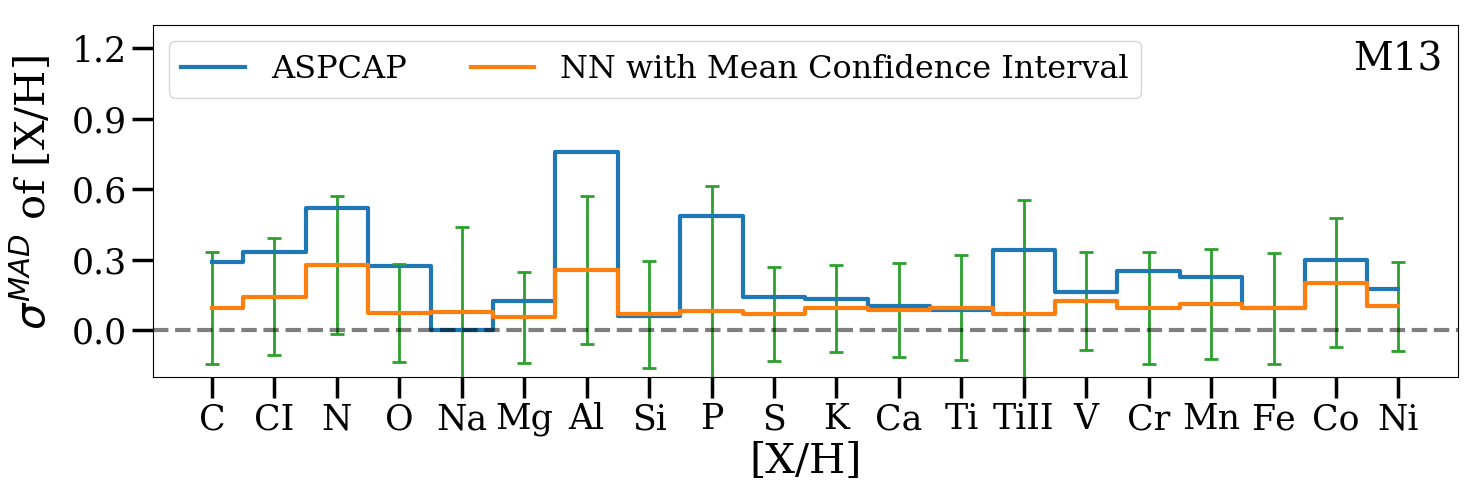

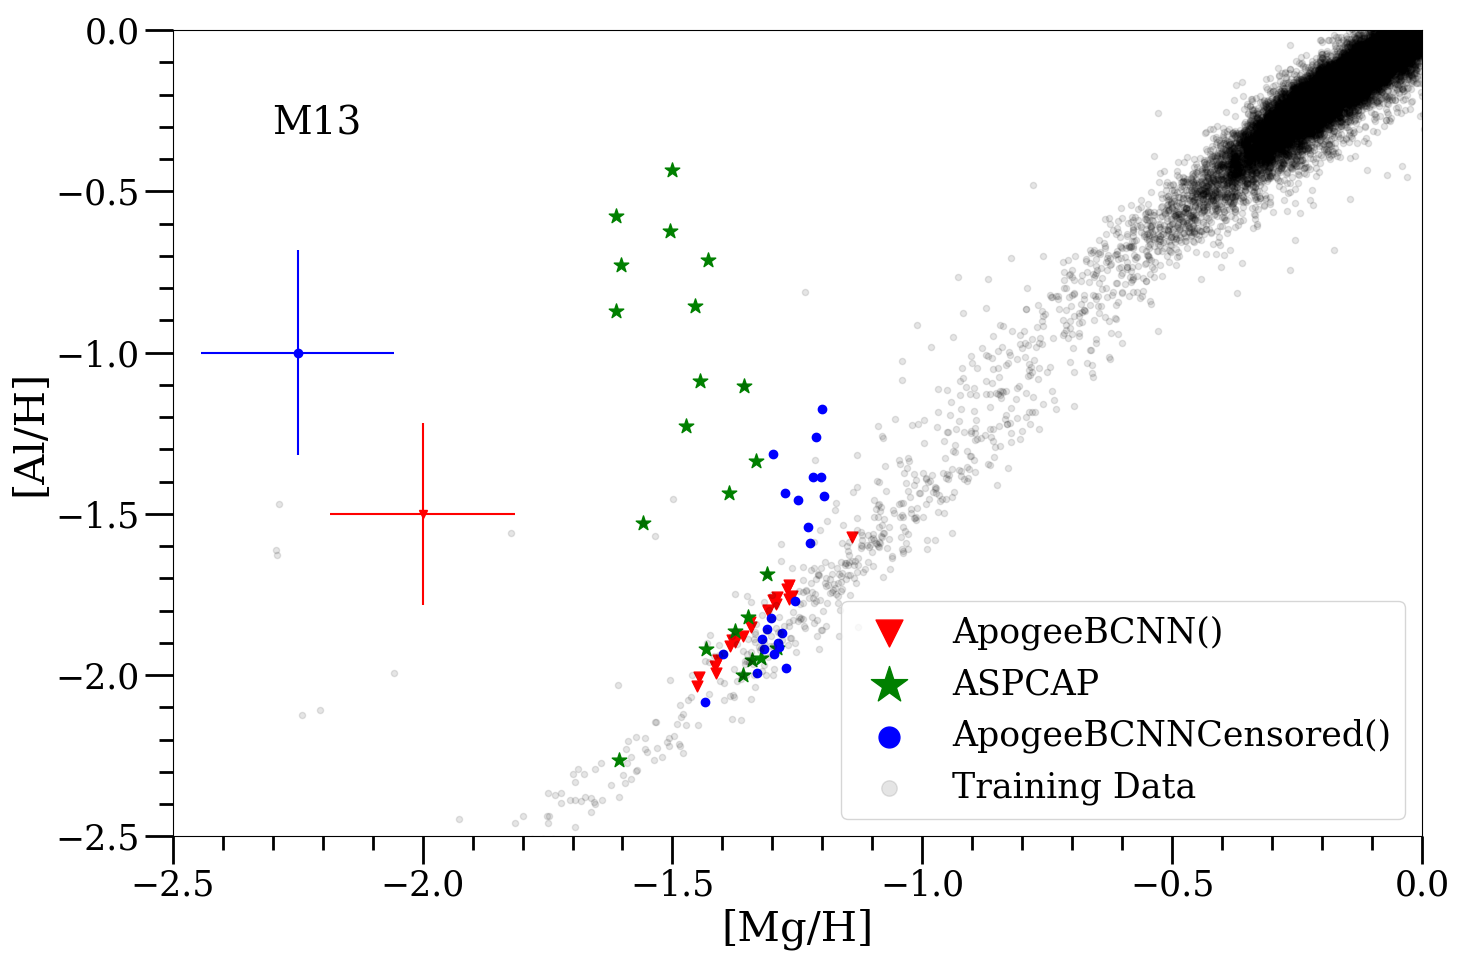

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
import astropy.io.ascii
from astropy.stats import mad_std
from astropy.io import fits

from astroNN.apogee import allstar, allstarcannon
from astroNN.apogee import visit_spectra
from astroNN.apogee.chips import apogee_continuum
from astroNN.models import load_folder
from astroNN.datasets import H5Loader
from astroNN.models import load_folder

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Load the dataset testing data
loader = H5Loader('__train')
loader.load_combined = True  # load individual visits
loader.load_err = False
# load the correct entry with correct order from ApogeeBCNNcensored
loader.target = ['Mg', 'Al']
x, y = loader.load()

# we dont need spectra here
del x

# load APOGEE allstar file
all_star = fits.getdata(allstar(dr=14))
allstar_cannon = fits.getdata(allstarcannon(dr=14))
not_starflagged = (all_star['STARFLAG'] == 0)

# Same target bit used in the paper
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

# setup the continuum normalization function such that did the same thing as the standard procedure used in the paper
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# load the trained neural network model described in the paper
bcnn = load_folder('astroNN_0617_run001')
targetname = bcnn.targetname[2:]  # find out which neural repsondable to what

# load open cluster data
data = astropy.io.ascii.read('aj485195t4_mrt.txt')
uni_names = np.unique(np.array(data['col2']))  # find unique cluster name

# loop throught the clusters
for name in uni_names:
    # In the paper, we only plot these M13 in globular cluster category
    if name not in ['M13']:
        continue
                
    # find all the APOGEE ID associated with that cluster
    apogeeid_name_idx = np.where(data['col2']==name)
     # find indices for those APOGEE ID in allstar
    indices = np.where(np.in1d(all_star['APOGEE_ID'][not_starflagged], data['col1'][apogeeid_name_idx]))[0]
    # retrieve info on those APOGEE spectra
    aid = all_star['APOGEE_ID'][not_starflagged][indices]
    loc_id = all_star['LOCATION_ID'][not_starflagged][indices]
    # 0-20 are indices representing output neurones from ASPCAP chemical abundances (C/H to Ni/H)
    aspcap_result = all_star['X_H'][not_starflagged][indices, 0:20]
    aspcap_result_err = all_star['X_H_ERR'][not_starflagged][indices, 0:20]

    cannon_result_mg = allstar_cannon['MG_H'][not_starflagged][indices]
    cannon_result_al = allstar_cannon['AL_H'][not_starflagged][indices]
    cannon_result_n = allstar_cannon['N_H'][not_starflagged][indices]
    cannon_result_ti2 = allstar_cannon['TIII_H'][not_starflagged][indices]
    cannon_result_p = allstar_cannon['P_H'][not_starflagged][indices]
    cannon_result_fe = allstar_cannon['Fe_H'][not_starflagged][indices]
    cannon_result_c = allstar_cannon['C_H'][not_starflagged][indices]
    cannon_result_o = allstar_cannon['O_H'][not_starflagged][indices]

    # pre-allocation of spectra array
    spec = np.zeros((indices.shape[0], 7514))

    for counter, idx in enumerate(aid):
        apstar_file = fits.open(visit_spectra(dr=14, location=loc_id[counter], apogee=aid[counter], verbose=0))
        nvisits = apstar_file[0].header['NVISITS']
        # we want combined spectra
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        # continuum normalization of spectra
        _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
        spec[counter] = _spec
        apstar_file.close()

    print(name, ' and number of stars: ', indices.shape[0])
    
    # Bayesian Neural Network Inference
    pred, pred_err = bcnn.test(spec)
    # 4-24 are indices representing ASPCAP chemical abundances from output neurones (C/H to Ni/H)
    m13_nn_scatter = mad_std(pred[:,2:], axis=0)
    m13_nn_m_uncer = np.mean(pred_err['total'][:,2:], axis=0)
    m13_aspcap = mad_std(aspcap_result, axis=0)

    m13_aspcap_mean = np.mean(aspcap_result, axis=0)
    m13_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])
    
    m13_nn_mean = np.mean(pred[:,2:], axis=0)
    m13_nn_uncer_in_mean = mad_std(pred[:,2:], axis=0) / np.sqrt(indices.shape[0])
    
    print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
    for i in range(20):
        print(targetname[i], f': {m13_nn_mean[i]:.{4}f}+/-{m13_nn_uncer_in_mean[i]:.{4}f}', 
              f' ({m13_aspcap_mean[i]:.{4}f}+/-{m13_aspcap_uncer[i]:.{4}f})')
        
    print('Neural Network star cluster median abundances and scattering (ASPCAP)')
    m13_nn_mean_fe = m13_nn_mean - m13_nn_mean[17]
    m13_nn_scatter_fe = mad_std(pred[:,2:]-pred[:,19:20], axis=0)
    m13_aspcap_mean_fe = m13_aspcap_mean - m13_aspcap_mean[17]
    m13_aspcap_scatter_fe = mad_std(aspcap_result-aspcap_result[:,16:17], axis=0)
    for i in range(20):
        print(targetname[i], f': {m13_nn_mean_fe[i]:.{4}f}+/-{m13_nn_scatter_fe[i]:.{4}f}', 
              f' ({m13_aspcap_mean_fe[i]:.{4}f}+/-{m13_aspcap_scatter_fe[i]:.{4}f})')

# load the neural network trained on the full spectra
bcnn_full = load_folder('astroNN_0606_run001')
pred_full, pred_full_err = bcnn_full.test(spec[1:])

# print('=====Cannon======')
# print('N/H: ', np.median(cannon_result_n, axis=0), ' +/- ', mad_std(cannon_result_n, axis=0) / np.sqrt(indices.shape[0]))
# print('P/H: ', np.median(cannon_result_p, axis=0), ' +/- ', mad_std(cannon_result_p, axis=0) / np.sqrt(indices.shape[0]))
# print('Ti2/H: ', np.median(cannon_result_ti2, axis=0), ' +/- ', mad_std(cannon_result_ti2, axis=0) / np.sqrt(indices.shape[0]))
# print('Mg/H: ', np.median(cannon_result_mg, axis=0), ' +/- ', mad_std(cannon_result_mg, axis=0) / np.sqrt(indices.shape[0]))
# print('Al/H: ', np.median(cannon_result_al, axis=0), ' +/- ', mad_std(cannon_result_al, axis=0) / np.sqrt(indices.shape[0]))
# print('Fe/H: ', np.median(cannon_result_fe, axis=0), ' +/- ', mad_std(cannon_result_fe, axis=0) / np.sqrt(indices.shape[0]))
# print('C/H: ', np.median(cannon_result_c, axis=0), ' +/- ', mad_std(cannon_result_c, axis=0) / np.sqrt(indices.shape[0]))
# print('O/H: ', np.median(cannon_result_o, axis=0), ' +/- ', mad_std(cannon_result_o, axis=0) / np.sqrt(indices.shape[0]))
ml = MultipleLocator(0.04)        

for ii in range(len(bcnn.targetname[2:])):
    bcnn.targetname[2+ii] = bcnn.targetname[2+ii].replace("/H]", "")
    bcnn.targetname[2+ii] = bcnn.targetname[2+ii].replace("[", "")

# setup plots
f, ax = plt.subplots(1, figsize=(15, 5.32), dpi=100)

ax.plot(m13_aspcap, ls='steps-mid', linewidth=3., label='ASPCAP')
ax.plot(m13_nn_scatter, ls='steps-mid', linewidth=3., label='NN with Mean Confidence Interval')
ax.errorbar(np.arange(20), m13_nn_scatter, yerr=m13_nn_m_uncer, linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax.legend(loc='upper left', fontsize=23, ncol=2)

ax.annotate("M13", xy=(0.92,0.87),xycoords='axes fraction', fontsize=28)
ax.set_xlabel('[X/H]', fontsize=30)
ax.set_ylim((-0.20, 1.3))
ax.set_xticks(np.arange(len([xn for xn in bcnn.targetname[2:]])))
ax.set_xticklabels([f"{xn}" for xn in bcnn.targetname[2:]])
ax.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax.yaxis.set_major_locator(MultipleLocator(0.3))
ax.axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)

f.text(0.02, 0.60, r'$\sigma^{MAD}$' +  ' of [X/H]', ha='center', 
       va='center', fontdict={'fontsize':30}, rotation='vertical')
f.tight_layout()
f.subplots_adjust(left=0.1)
f.savefig('m13.pdf')


f, ax = plt.subplots(1, figsize=(15,10), dpi=100)
ax.annotate("M13", xy=(0.08,0.87),xycoords='axes fraction', fontsize=28)
ax.scatter(pred_full[:,7], pred_full[:,8], rasterized=True, label='ApogeeBCNN()', s=60., marker='v', color='red')
ax.scatter(aspcap_result[:, 5], aspcap_result[:, 6], rasterized=True, label='ASPCAP', s=120., marker='*', color='green')
ax.scatter(pred[:,7], pred[:,8], rasterized=True, label='ApogeeBCNNCensored()', color='blue')
ax.scatter(y[:,0], y[:,1], rasterized=True, label='Training Data', s=20., c='k', alpha=0.1)
# ax.scatter(cannon_result_mg, cannon_result_al, marker='v', alpha=0.8, label='Cannon DR14')
ax.tick_params(labelsize=25, width=2, length=20, which='major')
ax.tick_params(width=2, length=10, which='minor')
ax.minorticks_on()
ax.set_xlim((-2.5,-0.0))
ax.set_ylim((-2.5,-0.0))
ax.legend(loc='lower right', fontsize=25, markerscale=2.5)
ax.set_xlabel("[Mg/H]", fontsize=30)
ax.set_ylabel("[Al/H]", fontsize=30)
ax.errorbar(-2.25, -1.0, xerr=np.mean(pred_err['total'][:,7]), yerr=np.mean(pred_err['total'][:,8]), rasterized=True, marker='o', color='blue')
ax.errorbar(-2., -1.5, xerr=np.mean(pred_full_err['total'][:,7]), yerr=np.mean(pred_full_err['total'][:,8]), rasterized=True, marker='v', color='red')

f.tight_layout()
f.savefig('m13_al_mg.pdf')